# Import Statements

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import healpy as hp
import astropy
from astropy.time import Time
from datetime import datetime
import time
import scipy
from scipy.stats import linregress
import math
import csv

# Loading the files into Jupyter Notebook

In [11]:
rates_data = np.load('/home/rykore/rates_data.npy', allow_pickle = True).item()
# weather_data = np.load('/home/rykore/weather_data.npy', allow_pickle = True).item()
mean_std_lin = np.load('/home/rykore/mean_std_lin.npy', allow_pickle = True).item()
mean_std_exp = np.load('/home/rykore/mean_std_exp.npy', allow_pickle = True).item()

In [12]:
mean_std_exp

{'2015': {'mean_unscaled_exp': -0.008339175445360591,
  'std_unscaled_exp': 0.011949026090978563},
 '2016': {'mean_unscaled_exp': -0.008315750974476396,
  'std_unscaled_exp': 0.004535110487897894},
 '2017': {'mean_unscaled_exp': -0.008065171472830552,
  'std_unscaled_exp': 0.0031419891320336483},
 '2018': {'mean_unscaled_exp': -0.007878135670018362,
  'std_unscaled_exp': 0.0033351306455870135},
 '2019': {'mean_unscaled_exp': -0.008374863958619272,
  'std_unscaled_exp': 0.002396134558974139},
 '2020': {'mean_unscaled_exp': -0.008458311690858998,
  'std_unscaled_exp': 0.0025517904739602534},
 '2021': {'mean_unscaled_exp': -0.008032398364266601,
  'std_unscaled_exp': 0.0039600528894163205},
 '2022': {'mean_unscaled_exp': -0.00848412591873162,
  'std_unscaled_exp': 0.004687454318885889}}

In [65]:
print(len(weather_data['2019']['mjd_time_weather']))

525600


In [5]:
print(len(rates_data['2019']['mjd_time_rates']))

112173


# Files for Rates and Weather

In [14]:
rates_path = '/home/rykore/rates/'
weather_path = '/home/rykore/weather/'

In [15]:
rates_file_name = sorted(os.listdir(rates_path))
rates_file = []
for file_name in rates_file_name:
    rates_file.append(rates_path + file_name)
print(rates_file)

['/home/rykore/rates/hawc-rates_2015.txt', '/home/rykore/rates/hawc-rates_2016.txt', '/home/rykore/rates/hawc-rates_2017.txt', '/home/rykore/rates/hawc-rates_2018.txt', '/home/rykore/rates/hawc-rates_2019.txt', '/home/rykore/rates/hawc-rates_2020.txt', '/home/rykore/rates/hawc-rates_2021.txt', '/home/rykore/rates/hawc-rates_2022.txt', '/home/rykore/rates/hawc-rates_2023.txt']


In [16]:
weather_file_name = sorted(os.listdir(weather_path))
weather_file =[]
for file_name in weather_file_name:
    weather_file.append(weather_path + file_name)

print(weather_file)

['/home/rykore/weather/hawc-weather-2012.txt', '/home/rykore/weather/hawc-weather-2013.txt', '/home/rykore/weather/hawc-weather-2014.txt', '/home/rykore/weather/hawc-weather-2015.txt', '/home/rykore/weather/hawc-weather-2016.txt', '/home/rykore/weather/hawc-weather-2017.txt', '/home/rykore/weather/hawc-weather-2018.txt', '/home/rykore/weather/hawc-weather-2019.txt', '/home/rykore/weather/hawc-weather-2020.txt', '/home/rykore/weather/hawc-weather-2021.txt', '/home/rykore/weather/hawc-weather-2022.txt', '/home/rykore/weather/hawc-weather-2023.txt']


In [17]:
def get_common_paths(rates_file, weather_file):
    
    rates_years = {file.split('_')[-1][:4]: file for file in rates_file}
    weather_years = {file.split('-')[-1][:4]: file for file in weather_file}

    common_years = sorted(rates_years.keys() & weather_years.keys())

    rates_file_path = [rates_years[year] for year in common_years]
    weather_file_path = [weather_years[year] for year in common_years]

    return rates_file_path, weather_file_path, common_years


# Convert_file function

In [18]:
def convert_file(file_path):
    if 'rates' in file_path:
        df = pd.read_csv(file_path, delim_whitespace=True, usecols=[1, 2, 3, 4], header=None, skiprows=1)
        df.columns = ['Date', 'Time', 'Rate', 'LivePMTs']
        df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce', utc = True)

        # filter out rows with NaT in 'DateTime'
        df = df.dropna(subset=['DateTime'])

        df = df[df['LivePMTs'] != 0]

        # applying the cuts to rates to exclude the unwanted data
        cut = (np.abs(df['Rate'].astype(float) - np.mean(df['Rate'].astype(float))) < (np.std(df['Rate'].astype(float)) * 5))
        df = df[cut]

        # convert the 'DateTime' column to an array of 'datetime.datetime' objects
        datetime_objects = df['DateTime'].dt.to_pydatetime()

        # convert DateTime to MJD
        mjd_values = Time(datetime_objects, format='datetime', scale='utc').mjd

        # convert Rate and LivePMTs to float
        rates = df['Rate'].astype(float).to_numpy()
        livepmts = df['LivePMTs'].astype(float).to_numpy()

        return mjd_values, rates, livepmts

    elif 'weather' in file_path:
        df = pd.read_csv(file_path, delim_whitespace=True, usecols=[0, 1, 2, 3, 4, 5], header=None, skiprows=9)
        df.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Pressure']

        # Combine Year, Month, Day, Hour, and Minute into a single DateTime column and parse
        df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).agg('-'.join, axis=1), 
                                        format='%Y-%m-%d-%H-%M', errors='coerce',utc = True )

        # Filter out rows with NaT in 'DateTime'
        df = df.dropna(subset=['DateTime'])

        # Convert the 'DateTime' column to an array of 'datetime.datetime' objects
        datetime_objects_weather = df['DateTime'].dt.to_pydatetime()

        # Convert DateTime to MJD
        mjd_values_weather = Time(datetime_objects_weather, format='datetime', scale='utc').mjd

        # Convert Pressure to float
        pressure_total = df['Pressure'].astype(float).to_numpy()

        return mjd_values_weather, pressure_total


In [19]:
rates_file_path , weather_file_path, years = get_common_paths(rates_file, weather_file)
print(rates_file_path)
print(weather_file_path)
print(len(rates_file_path))
print(len(weather_file_path))
print(years)

['/home/rykore/rates/hawc-rates_2015.txt', '/home/rykore/rates/hawc-rates_2016.txt', '/home/rykore/rates/hawc-rates_2017.txt', '/home/rykore/rates/hawc-rates_2018.txt', '/home/rykore/rates/hawc-rates_2019.txt', '/home/rykore/rates/hawc-rates_2020.txt', '/home/rykore/rates/hawc-rates_2021.txt', '/home/rykore/rates/hawc-rates_2022.txt', '/home/rykore/rates/hawc-rates_2023.txt']
['/home/rykore/weather/hawc-weather-2015.txt', '/home/rykore/weather/hawc-weather-2016.txt', '/home/rykore/weather/hawc-weather-2017.txt', '/home/rykore/weather/hawc-weather-2018.txt', '/home/rykore/weather/hawc-weather-2019.txt', '/home/rykore/weather/hawc-weather-2020.txt', '/home/rykore/weather/hawc-weather-2021.txt', '/home/rykore/weather/hawc-weather-2022.txt', '/home/rykore/weather/hawc-weather-2023.txt']
9
9
['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


# Converting rates and weather files to plot them

In [20]:
# apply the cuts here
rates_data = {}
weather_data = {}
years = {}

start = time.time()


#checking if the for loop is parsing through corresponding elements in the two sequences
for rates_path, weather_path in zip(rates_file_path, weather_file_path):
    
    year = rates_path.split('_')[-1].split('.')[0]
    
    mjd_time_rates, rates, livepmts = convert_file(rates_path)
    rates_over_pmt = rates/livepmts
    rates_modified = rates/1e3
    rates_data[year] = {'mjd_time_rates': mjd_time_rates, 'rates': rates, 'rates_modified': rates_modified, 'rates_over_pmt': rates_over_pmt}

    mjd_time_weather, pressure = convert_file(weather_path)
    weather_data[year] = {'mjd_time_weather': mjd_time_weather, 'pressure': pressure}

end = time.time()

print(end-start, "seconds")

65.57359838485718 seconds


In [21]:
print(rates_data['2023']['mjd_time_rates'][:5])
print(weather_data['2019']['mjd_time_weather'][:5])

[59944.75059606 59944.75204282 59944.75348958 59944.7563831
 59944.75927662]
[58484.         58484.00069444 58484.00138889 58484.00208333
 58484.00277778]


In [22]:
print(rates_data['2021']['rates_modified'][:5])
print(weather_data['2021']['pressure'][:5])

[24.699552 24.71428  24.711808 24.682512 24.688296]
[622.075 622.238 622.238 622.238 622.238]


# make_plot() function

In [23]:
def make_plot(year, weather_lower_y = 0 , weather_upper_y = 0 , rates_lower_y = 0, rates_upper_y = 0, const = 2, make_plot = False):

    xmin = min(weather_data[year]['mjd_time_weather'])
    xmax = max(weather_data[year]['mjd_time_weather'])

    if make_plot == True:

        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        ax1.plot(weather_data[year]['mjd_time_weather'], weather_data[year]['pressure'], ".", label='Pressure', color='blue')
        ax1.set_ylim(weather_lower_y, weather_upper_y)
        # ax1.set_xlim(0, xmax - xmin)
        
        ax1.set_xlabel('MJD-%s' % xmin, fontsize=18)
        ax1.set_ylabel('Pressure (mbar)', fontsize=20, color='blue')
        ax1.tick_params('y', colors='blue')
        ax1.legend(loc='lower left', numpoints=1, fontsize=18)
        ax1.grid(True)
        
        for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
            item.set_fontsize(18)
        
        ax2 = ax1.twinx()
    
        # Plot rate data on secondary y-axis (ax2)
        # ax2.plot(mjd_time_rates, rates, ".", label='Rate', color='red')
        ax2.plot(rates_data[year]['mjd_time_rates'], rates_data[year]['rates_modified'], ".", label='Rates', color='red')
        ax2.plot(rcorr_final[year]['time'], (rcorr_final[year]['corrected rates']/1e3) - const, ".", color='black')
        ax2.set_ylim(rates_lower_y,rates_upper_y)
    
        ax2.set_ylabel('Data Rate (Hz)', fontsize=20, color='red')
        ax2.tick_params('y', colors='red')
        ax2.legend(loc='lower right', numpoints=1, fontsize=18)
        
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(18)
        
        # Title
        plt.title('HAWC Atmospheric Pressure - {0}'.format(year), fontsize=17)
        
        fig.tight_layout()
        
        plt.show()

    if make_plot == False:

        return xmin, xmax

# Slope of fit line for each day

In [24]:
def get_slope(year, set_xmin, set_xmax, linear = True):
    
    time_range = set_xmax - set_xmin
    delta = 5.55e-03  # this is 8 mins in units of days
    bins = int(time_range / delta)

    weather_times = np.array(weather_data[year]['mjd_time_weather'])
    weather_pressures = np.array(weather_data[year]['pressure'])
    rates_times = np.array(rates_data[year]['mjd_time_rates'])
    rates_values = np.array(rates_data[year]['rates_modified'])

    # Filter weather data for the specified time range
    weather_mask = (weather_times >= set_xmin) & (weather_times <= set_xmax)
    filtered_weather_times = weather_times[weather_mask]
    filtered_weather_pressures = weather_pressures[weather_mask]
    
    # Calculate the average pressure in each bin
    avg_pressure, bin_edges_pressure = np.histogram(filtered_weather_times, bins = bins, weights = filtered_weather_pressures)
    avg_time_weather, bin_edges_time_weather = np.histogram(filtered_weather_times, bins = bins, weights = None)
    
    avg_pressure_per_time_interval = avg_pressure / avg_time_weather
    
    # Filter rates data for the specified time range
    rates_mask = (rates_times >= set_xmin) & (rates_times <= set_xmax)
    filtered_rates_times = rates_times[rates_mask]
    filtered_rates_values = rates_values[rates_mask]
    
    # Calculate the average rates in each bin
    avg_rates, bin_edges_rates = np.histogram(filtered_rates_times, bins = bins, weights = filtered_rates_values)
    avg_time_rates, bin_edges_time_rates = np.histogram(filtered_rates_times, bins = bins, weights = None)

    avg_rates_per_time_interval = np.full(avg_rates.shape, np.nan)

    non_zero_mask = avg_time_rates != 0
    avg_rates_per_time_interval[non_zero_mask] = avg_rates[non_zero_mask] / avg_time_rates[non_zero_mask]
    
    zero_mask = (avg_time_rates == 0)
    avg_rates_per_time_interval[zero_mask] = np.nan
    
    x_data = avg_pressure_per_time_interval
    y_data = avg_rates_per_time_interval
    
    # Remove NaN values for regression
    mask = (~np.isnan(x_data) & ~np.isnan(y_data))
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]

    # ask about this - is there a way to remove this?
    if len(x_data_clean) < 2 or len(y_data_clean) < 2:
        return np.nan
    
    # Perform linear regression
    # exonential fit
    if linear == True:
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)

    if linear == False:
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, np.log(y_data_clean))

    return slope


In [25]:
xmin_2018, xmax_2018 = make_plot('2018', make_plot = False)
slope_2018 = get_slope('2018', xmin_2018 + 10, xmin_2018 + 11, linear = True)
print(slope_2018)

-0.20817988438713989


In [26]:
rates_file_path , weather_file_path, years = get_common_paths(rates_file, weather_file)
print(rates_file_path)
print(weather_file_path)
print(len(rates_file_path))
print(len(weather_file_path))
print(years)

['/home/rykore/rates/hawc-rates_2015.txt', '/home/rykore/rates/hawc-rates_2016.txt', '/home/rykore/rates/hawc-rates_2017.txt', '/home/rykore/rates/hawc-rates_2018.txt', '/home/rykore/rates/hawc-rates_2019.txt', '/home/rykore/rates/hawc-rates_2020.txt', '/home/rykore/rates/hawc-rates_2021.txt', '/home/rykore/rates/hawc-rates_2022.txt', '/home/rykore/rates/hawc-rates_2023.txt']
['/home/rykore/weather/hawc-weather-2015.txt', '/home/rykore/weather/hawc-weather-2016.txt', '/home/rykore/weather/hawc-weather-2017.txt', '/home/rykore/weather/hawc-weather-2018.txt', '/home/rykore/weather/hawc-weather-2019.txt', '/home/rykore/weather/hawc-weather-2020.txt', '/home/rykore/weather/hawc-weather-2021.txt', '/home/rykore/weather/hawc-weather-2022.txt', '/home/rykore/weather/hawc-weather-2023.txt']
9
9
['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


In [27]:
years

['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [28]:
print(type(weather_data['2019']['mjd_time_weather']))

<class 'numpy.ndarray'>


# Getting the correlation coefficient for each day in that year

In [29]:
correlation_coefficients_lin = {}

for year in years:

    corr_coeff_lin = []

    xmin, xmax = make_plot(year , make_plot = False)
    i = xmin
    
    while (i <= xmax):
        slope = get_slope(year, i, i+1, linear = True)
        corr_coeff_lin.append(slope)
        i += 1

    correlation_coefficients_lin[year] = corr_coeff_lin

/tmp/ipykernel_1442/658963152.py:21: RuntimeWarning: invalid value encountered in divide
  avg_pressure_per_time_interval = avg_pressure / avg_time_weather


In [30]:
correlation_coefficients_exp = {}

for year in years:

    corr_coeff_exp = []

    xmin, xmax = make_plot(year , make_plot = False)
    i = xmin
    
    while (i <= xmax):
        slope = get_slope(year, i, i+1, linear = False)
        corr_coeff_exp.append(slope)
        i += 1

    correlation_coefficients_exp[year] = corr_coeff_exp

/tmp/ipykernel_1442/658963152.py:21: RuntimeWarning: invalid value encountered in divide
  avg_pressure_per_time_interval = avg_pressure / avg_time_weather


# Making a new txt file with all the data

In [31]:
def add_correlation_coefficients_to_weather_data_lin():
    
    for year, weather_info in weather_data.items():

        weather_info['DateTime'] = [Time(mjd, format='mjd', scale='utc').datetime for mjd in weather_info['mjd_time_weather']]
        weather_df = pd.DataFrame(weather_info)
        weather_df['Day'] = weather_df['DateTime'].dt.dayofyear
        
        # Initialize a column for correlation coefficients with NaNs
        weather_df['CorrCoeff_lin_unscaled'] = np.nan
        
        for day_of_year, corr_coeff in enumerate(correlation_coefficients_lin[year], start = 1):
            weather_df.loc[weather_df['Day'] == day_of_year, 'CorrCoeff_lin_unscaled'] = corr_coeff
            
        # Convert the DataFrame back to dictionary and update weather_data
        weather_data[year] = weather_df.to_dict('list')

        print("done!")

        # Write the modified data to a text file
        # write_weather_data_to_file_lin(weather_df, year)

def write_weather_data_to_file_lin(weather_df, year):
    directory = "/home/rykore/modified_weather_lin_unscaled"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f"modified_weather_{year}_lin_unscaled.txt")
    
    # Select only the columns you want to write to the file
    columns_to_write = ['mjd_time_weather', 'pressure', 'CorrCoeff_lin_unscaled']
    weather_df_to_write = weather_df[columns_to_write]
    
    with open(file_path, 'w') as file:
        weather_df_to_write.to_csv(file, index=False, sep='\t')


In [32]:
# linear fit
# dont run this unless necessary!!

add_correlation_coefficients_to_weather_data_lin()

done!
done!
done!
done!
done!
done!
done!
done!
done!


In [33]:
def add_correlation_coefficients_to_weather_data_exp():
    
    for year, weather_info in weather_data.items():

        weather_info['DateTime'] = [Time(mjd, format='mjd', scale='utc').datetime for mjd in weather_info['mjd_time_weather']]
        weather_df = pd.DataFrame(weather_info)
        weather_df['Day'] = weather_df['DateTime'].dt.dayofyear
        
        # Initialize a column for correlation coefficients with NaNs
        weather_df['CorrCoeff_exp_unscaled'] = np.nan
        
        for day_of_year, corr_coeff in enumerate(correlation_coefficients_exp[year], start = 1):
            weather_df.loc[weather_df['Day'] == day_of_year, 'CorrCoeff_exp_unscaled'] = corr_coeff
            
        # Convert the DataFrame back to dictionary and update weather_data
        weather_data[year] = weather_df.to_dict('list')

        print("done!")

        # Write the modified data to a text file
        # write_weather_data_to_file_exp(weather_df, year)

def write_weather_data_to_file_exp(weather_df, year):
    directory = "/home/rykore/modified_weather_exp_unscaled"
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f"modified_weather_{year}_exp_unscaled.txt")
    
    # Select only the columns you want to write to the file
    columns_to_write = ['mjd_time_weather', 'pressure', 'CorrCoeff_exp_unscaled']
    weather_df_to_write = weather_df[columns_to_write]
    
    with open(file_path, 'w') as file:
        weather_df_to_write.to_csv(file, index=False, sep='\t')

In [34]:
# exponential fit
# dont run this unless necessary!!
start = time.time()
add_correlation_coefficients_to_weather_data_exp()
end = time.time()

print((end - start)/ 60, "minutes")

done!
done!
done!
done!
done!
done!
done!
done!
done!
9.32103162209193 minutes


In [35]:
print(list(weather_data['2019'].keys()))

['mjd_time_weather', 'pressure', 'DateTime', 'Day', 'CorrCoeff_lin_unscaled', 'CorrCoeff_exp_unscaled']


In [36]:
print(list(rates_data['2019'].keys()))

['mjd_time_rates', 'rates', 'rates_modified', 'rates_over_pmt']


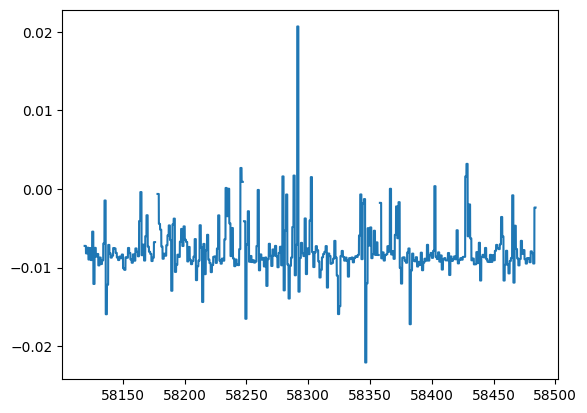

In [37]:
plt.plot(weather_data['2018']['mjd_time_weather'], weather_data['2018']['CorrCoeff_exp_unscaled'])

# Mean and Standard Deviation of the correlation coefficient for each year

In [38]:
mean_std_lin = {}
mean_std_exp = {}

# unique_corrCoeff_lin = {}
# unique_corrCoeff_exp = {}

unique_corrCoeff_lin_unsclaed = {}
unique_corrCoeff_exp_unsclaed = {}

def calculate_means_stds():
    for year, data in weather_data.items():
        
        weather_df = pd.DataFrame(data)
        
        unique_days_df = weather_df.drop_duplicates(subset=['Day'])

        # unique_corrCoeff_lin[year] = unique_days_df['CorrCoeff_lin']
        # unique_corrCoeff_exp[year] = unique_days_df['CorrCoeff_exp']

        unique_corrCoeff_lin_unsclaed[year] = unique_days_df['CorrCoeff_lin_unscaled']
        unique_corrCoeff_exp_unsclaed[year] = unique_days_df['CorrCoeff_exp_unscaled']
        
        # mean_lin = unique_days_df['CorrCoeff_lin'].mean()
        # std_lin = unique_days_df['CorrCoeff_lin'].std()

        mean_lin_unscaled = unique_days_df['CorrCoeff_lin_unscaled'].mean()
        std_lin_unscaled = unique_days_df['CorrCoeff_lin_unscaled'].std()

        # mean_exp = unique_days_df['CorrCoeff_exp'].mean()
        # std_exp = unique_days_df['CorrCoeff_exp'].std()

        mean_exp_unscaled = unique_days_df['CorrCoeff_exp_unscaled'].mean()
        std_exp_unscaled = unique_days_df['CorrCoeff_exp_unscaled'].std()

        # mean_std_lin[year] = {'mean': mean_lin, 'std': std_lin, 'mean_unscaled' : mean_lin_unscaled, 'std_unscaled' : std_lin_unscaled}
        # mean_std_exp[year] = {'mean': mean_exp, 'std': std_exp, 'mean_unscaled' : mean_exp_unscaled, 'std_unscaled' : std_exp_unscaled}

        mean_std_lin[year] = {'mean_unscaled_lin' : mean_lin_unscaled, 'std_unscaled_lin' : std_lin_unscaled}
        mean_std_exp[year] = {'mean_unscaled_exp' : mean_exp_unscaled, 'std_unscaled_exp' : std_exp_unscaled}

calculate_means_stds()


In [39]:
for key in mean_std_lin.keys():
    print(key)
    print(mean_std_lin[key])
    print(mean_std_exp[key])
    print()

2015
{'mean_unscaled_lin': -0.17987667463044033, 'std_unscaled_lin': 0.22409598161708333}
{'mean_unscaled_exp': -0.008339175445360591, 'std_unscaled_exp': 0.011949026090978563}

2016
{'mean_unscaled_lin': -0.20314040943150088, 'std_unscaled_lin': 0.1103527566842448}
{'mean_unscaled_exp': -0.008315750974476396, 'std_unscaled_exp': 0.004535110487897894}

2017
{'mean_unscaled_lin': -0.20158149235808812, 'std_unscaled_lin': 0.0783527327048637}
{'mean_unscaled_exp': -0.008065171472830552, 'std_unscaled_exp': 0.0031419891320336483}

2018
{'mean_unscaled_lin': -0.19652998316884154, 'std_unscaled_lin': 0.08263080295970152}
{'mean_unscaled_exp': -0.007878135670018362, 'std_unscaled_exp': 0.0033351306455870135}

2019
{'mean_unscaled_lin': -0.21076792869528313, 'std_unscaled_lin': 0.06007692972344306}
{'mean_unscaled_exp': -0.008374863958619272, 'std_unscaled_exp': 0.002396134558974139}

2020
{'mean_unscaled_lin': -0.20513965210432097, 'std_unscaled_lin': 0.062024609379112035}
{'mean_unscaled_exp

# Plotting the Gaussian Distribution of correlation coefficient

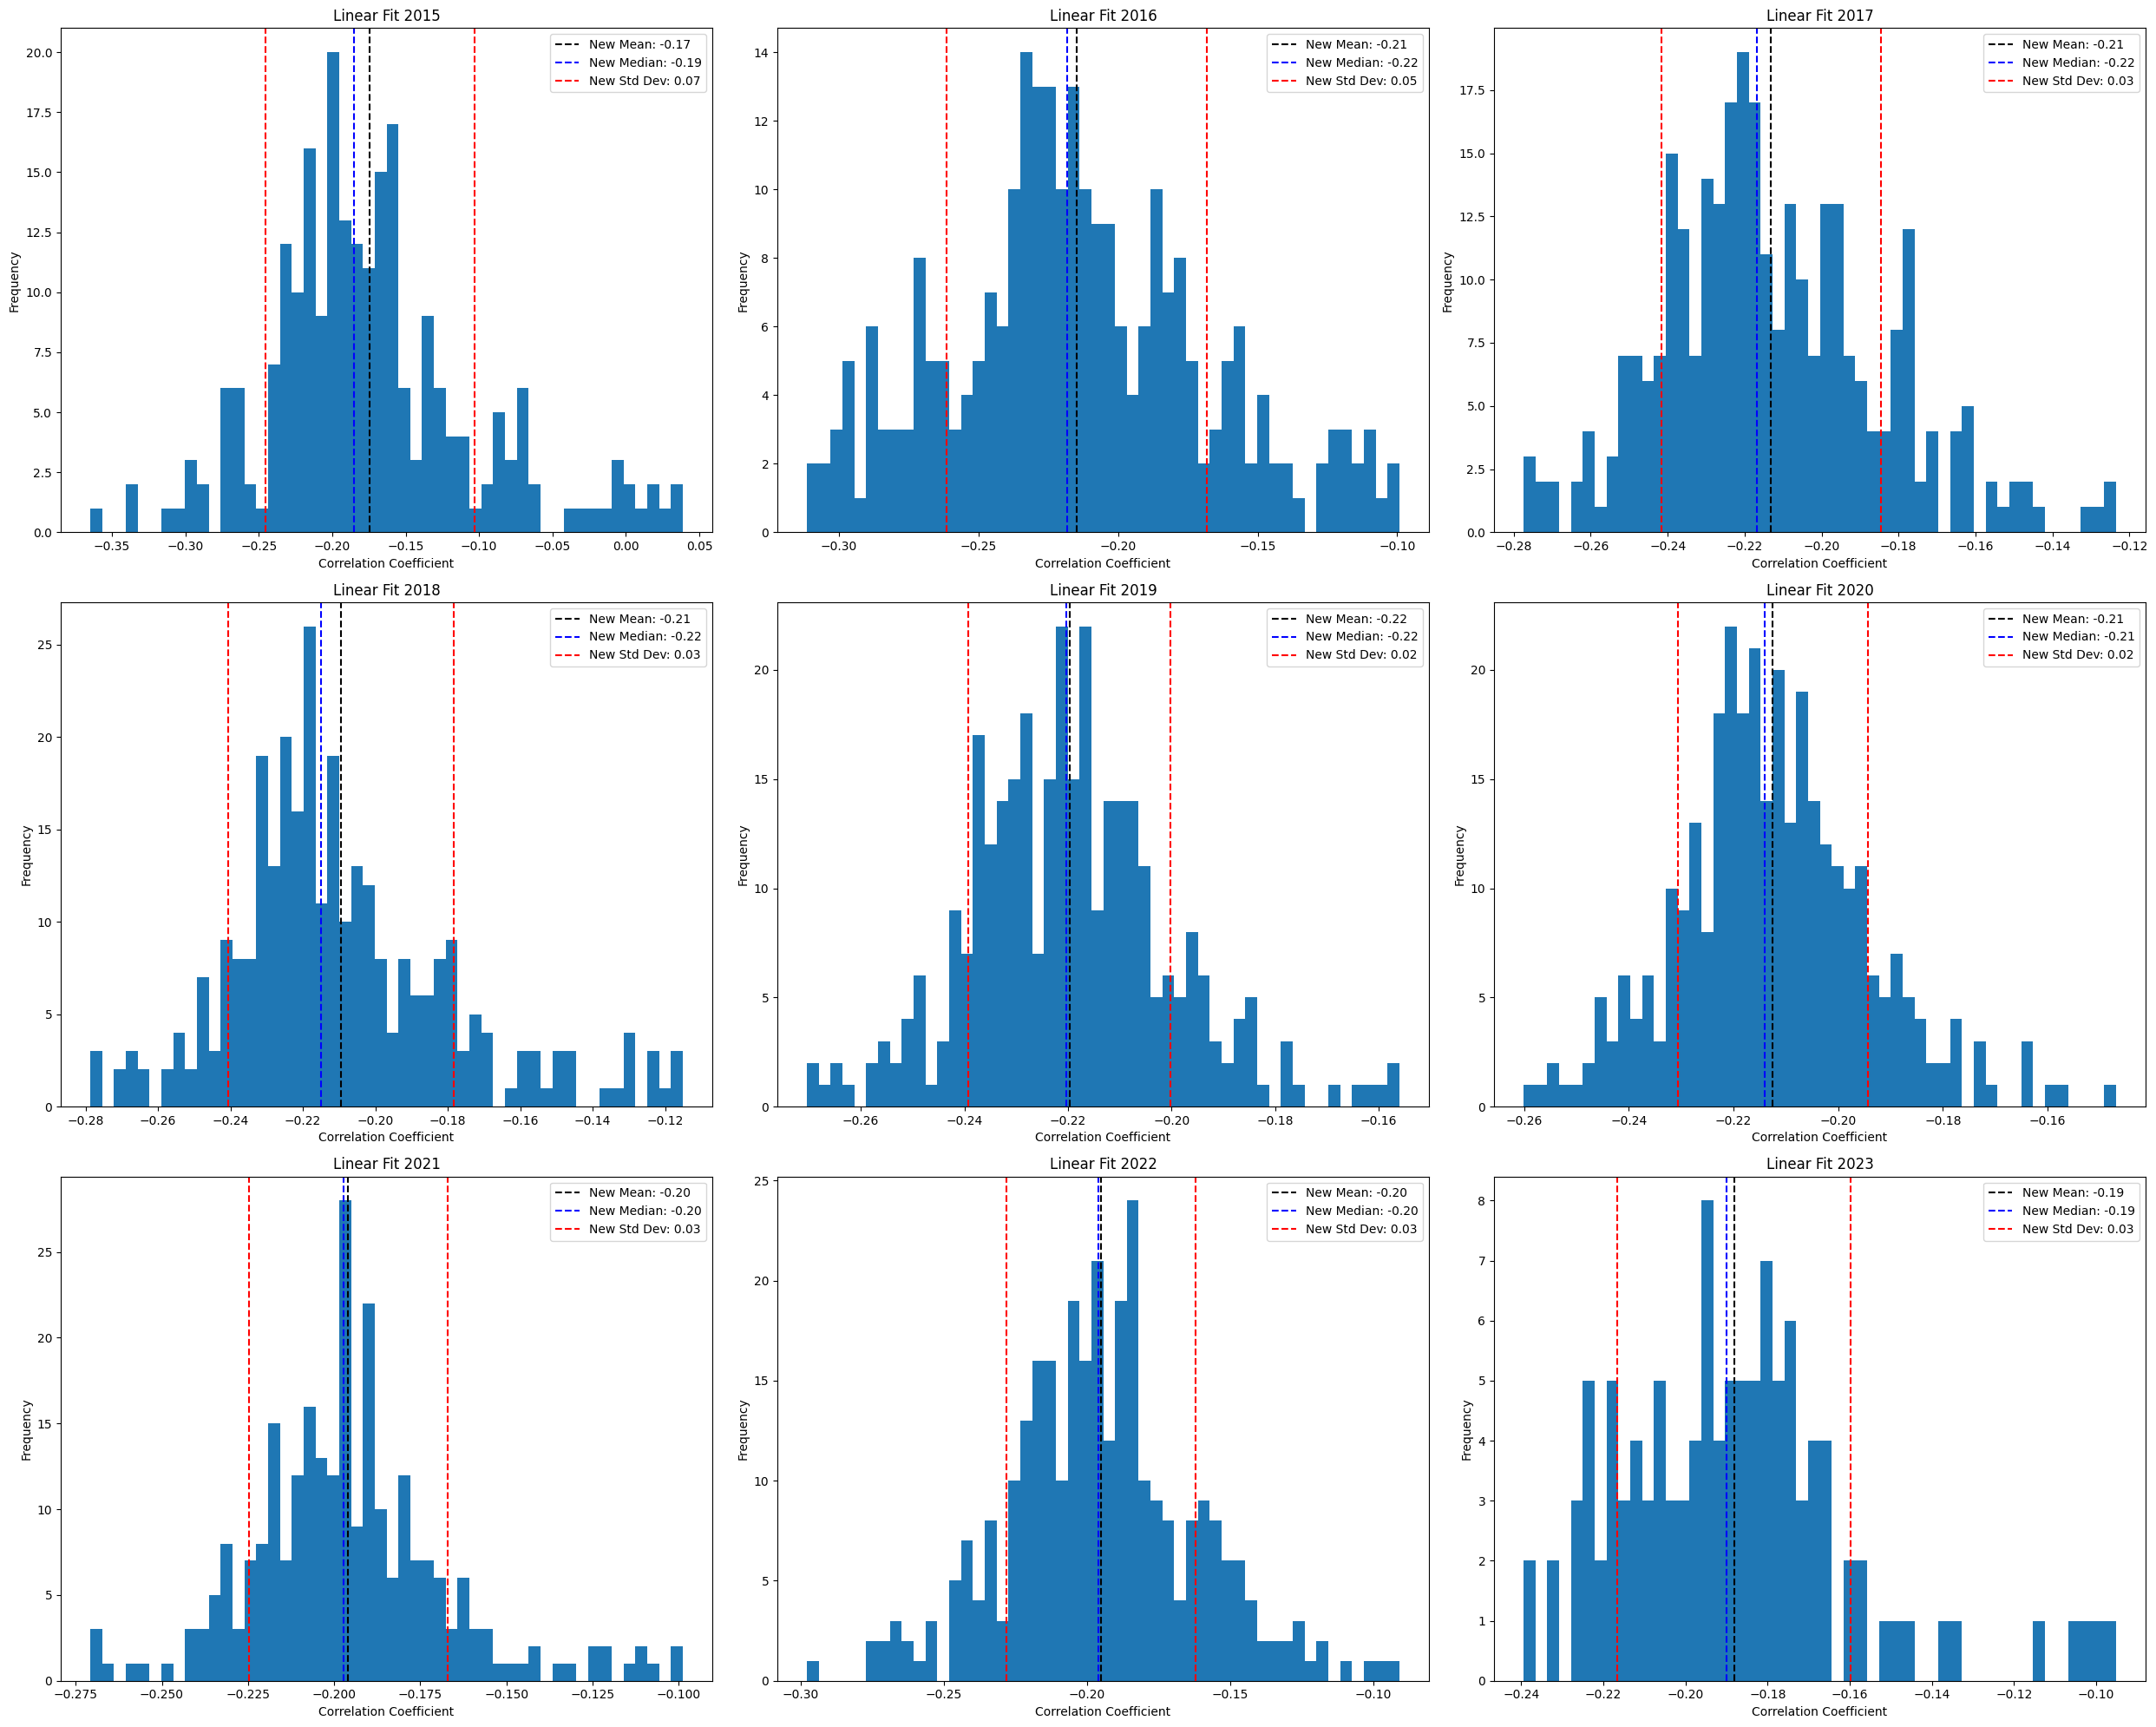

In [40]:
# combine all the graphs for all the years and make one graph
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20))

axes = axes.flatten()

for i, (year, data) in enumerate(unique_corrCoeff_lin_unsclaed.items()):

    mean = mean_std_lin[year]['mean_unscaled_lin']
    std = mean_std_lin[year]['std_unscaled_lin']

    # applied the cuts
    filtered_data_lin = data[(data > (mean - std)) & (data < (mean + std))]

    new_mean = filtered_data_lin.mean()
    new_median = filtered_data_lin.median()
    new_std = filtered_data_lin.std()

    ax = axes[i]
    # ax.hist(data, bins = 100)
    ax.hist(filtered_data_lin, bins = 50)
    # ax.axvline(x = mean, color='black', linestyle='--', label = f'Mean: {mean:.2f}')
    ax.axvline(x = new_mean, color='black', linestyle='--', label = f'New Mean: {new_mean:.2f}')
    ax.axvline(x = new_median, color='blue', linestyle='--', label = f'New Median: {new_median:.2f}')
    ax.axvline(x = new_mean + new_std, color='red', linestyle='--', label = f'New Std Dev: {new_std:.2f}')
    ax.axvline(x = new_mean - new_std, color='red', linestyle='--')
    ax.set_title(f'Linear Fit {year}')
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Frequency')
    ax.legend()

fig.tight_layout()

plt.show()

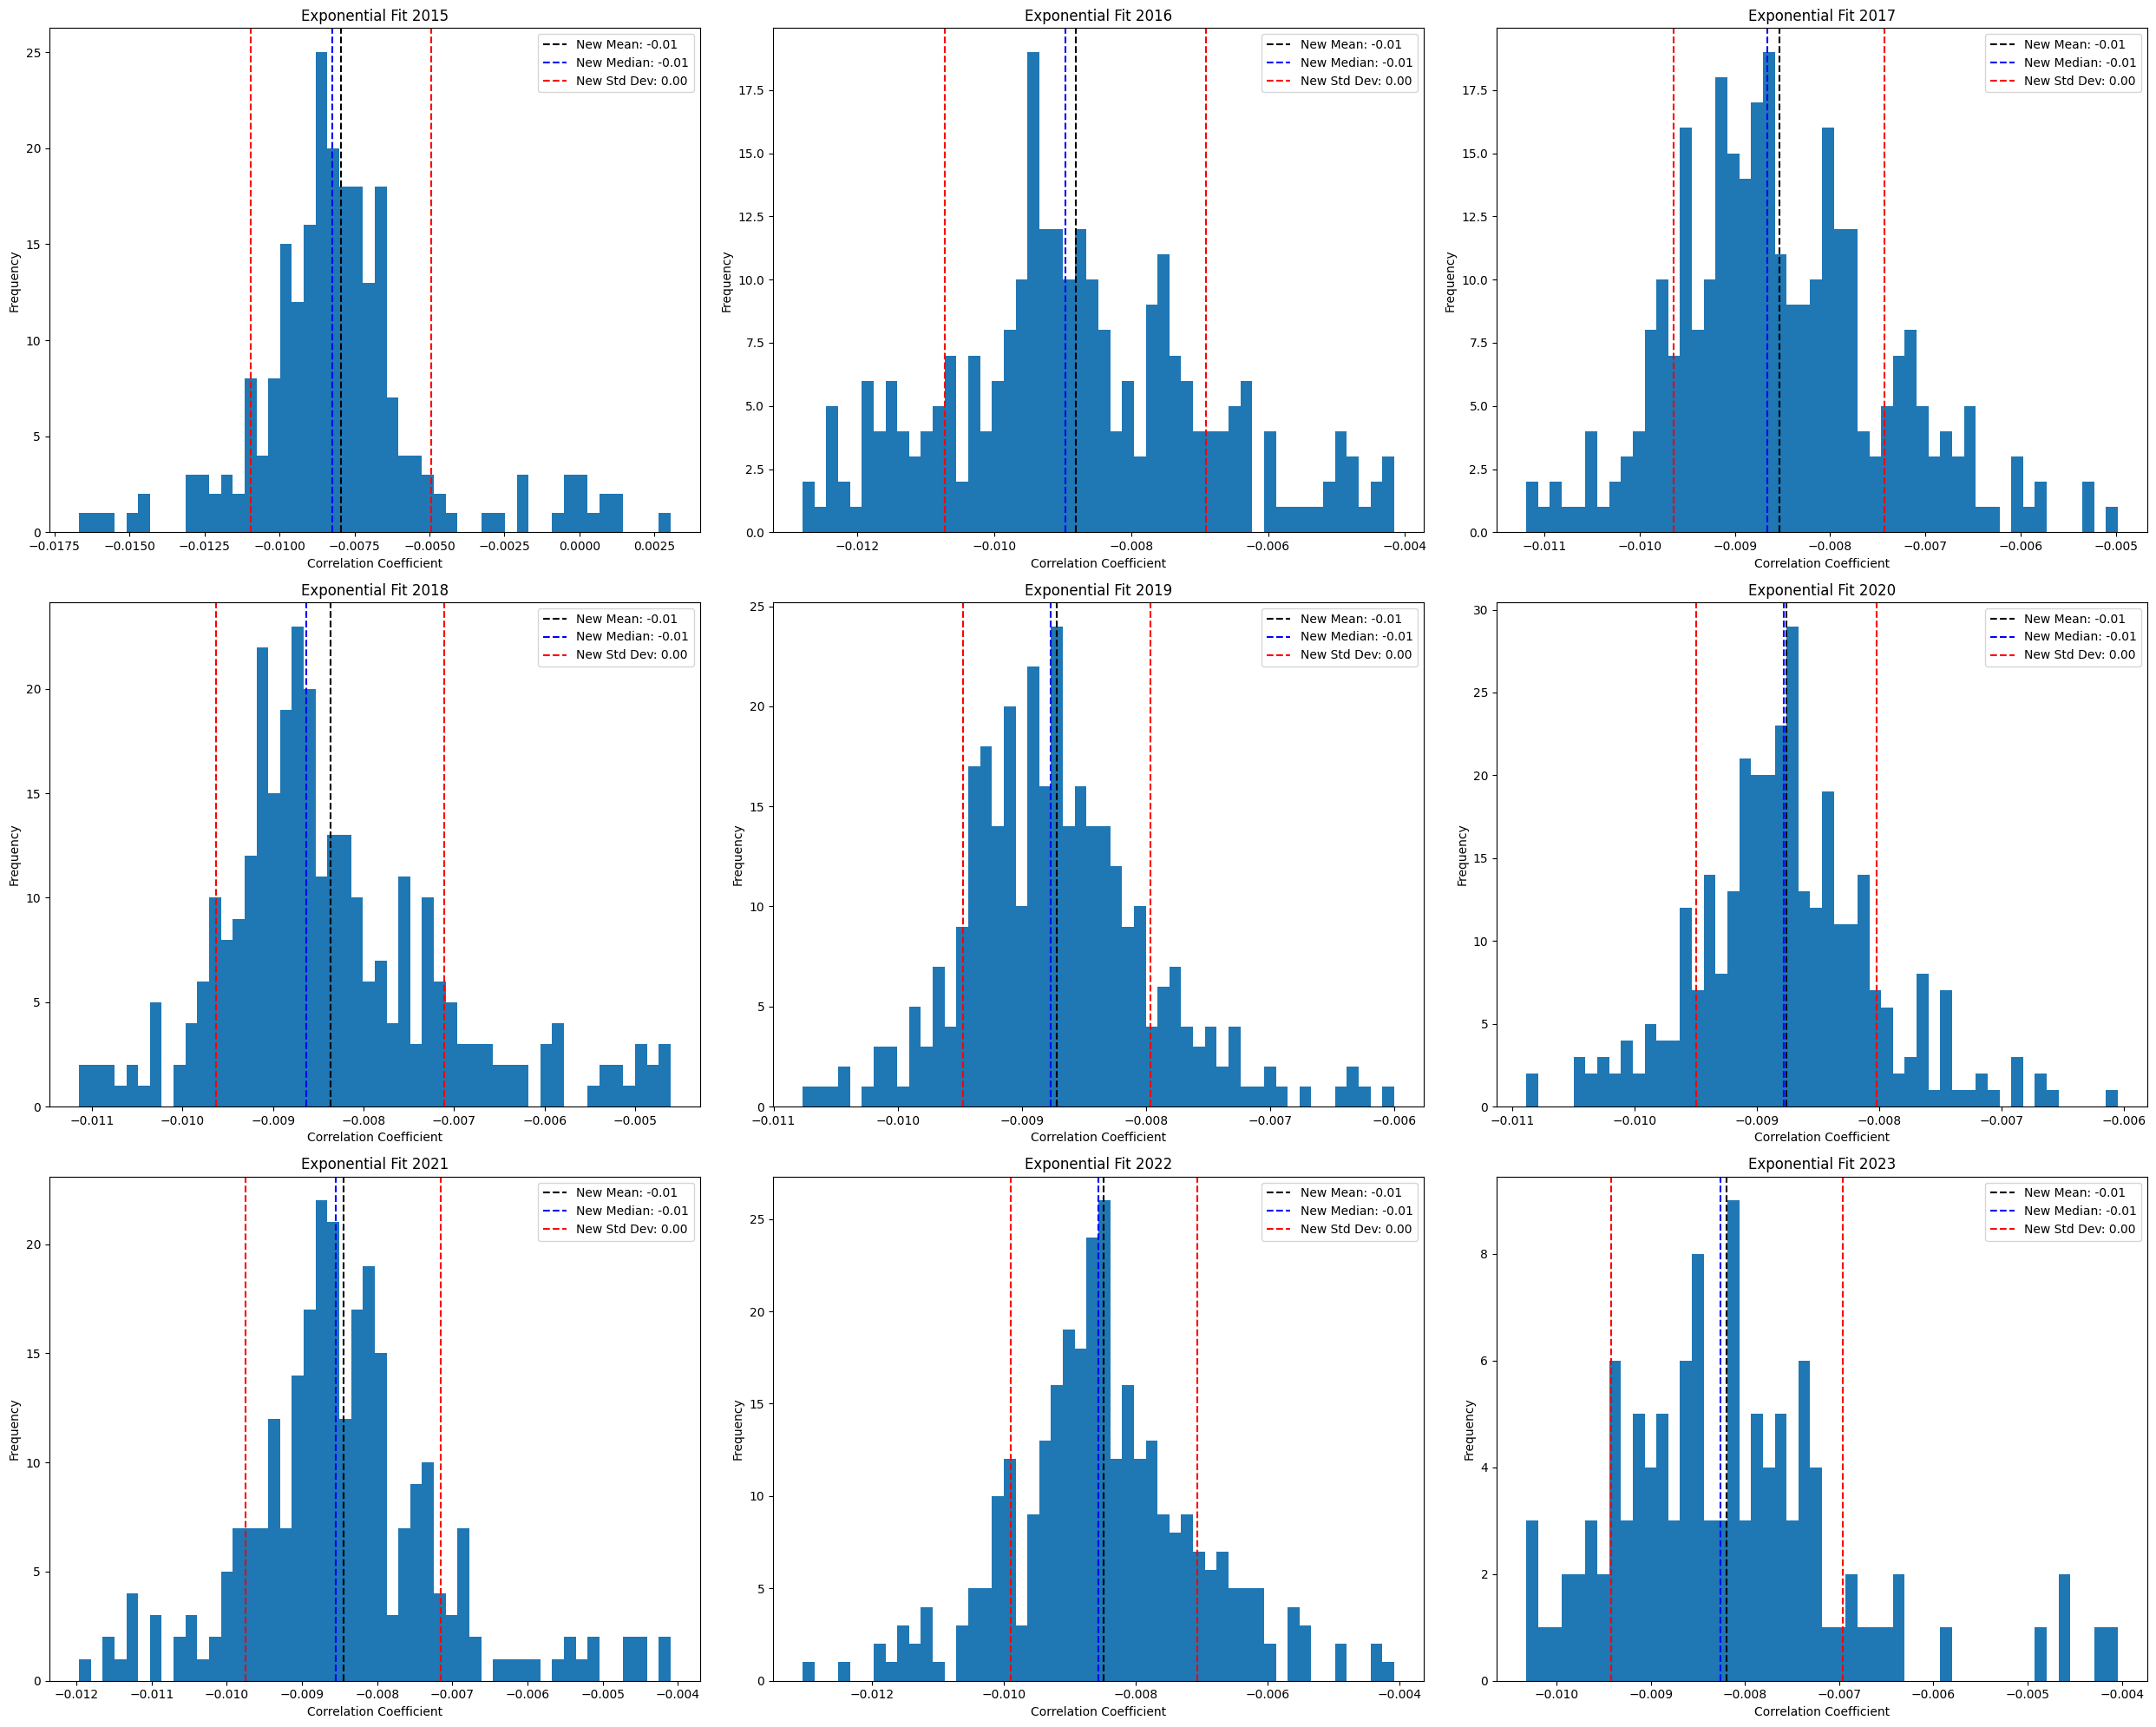

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20))
axes = axes.flatten()

for i, (year, data) in enumerate(unique_corrCoeff_exp_unsclaed.items()):

    mean = mean_std_exp[year]['mean_unscaled_exp']
    std = mean_std_exp[year]['std_unscaled_exp']

    filtered_data_exp = data[(data > (mean - std)) & (data < (mean + std))]

    new_mean = filtered_data_exp.mean()
    new_median = filtered_data_exp.median()
    new_std = filtered_data_exp.std()
    
    ax = axes[i]
    ax.hist(filtered_data_exp, bins = 50)
    # ax.axvline(x = mean, color='black', linestyle='--', label = f'Mean: {mean:.2f}')
    ax.axvline(x = new_mean, color='black', linestyle='--', label = f'New Mean: {new_mean:.2f}')
    ax.axvline(x = new_median, color='blue', linestyle='--', label = f'New Median: {new_median:.2f}')
    ax.axvline(x = new_mean + new_std, color='red', linestyle='--', label = f'New Std Dev: {new_std:.2f}')
    ax.axvline(x = new_mean - new_std, color='red', linestyle='--')
    ax.set_title(f'Exponential Fit {year}')
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Frequency')
    ax.legend()

fig.tight_layout()
plt.show()

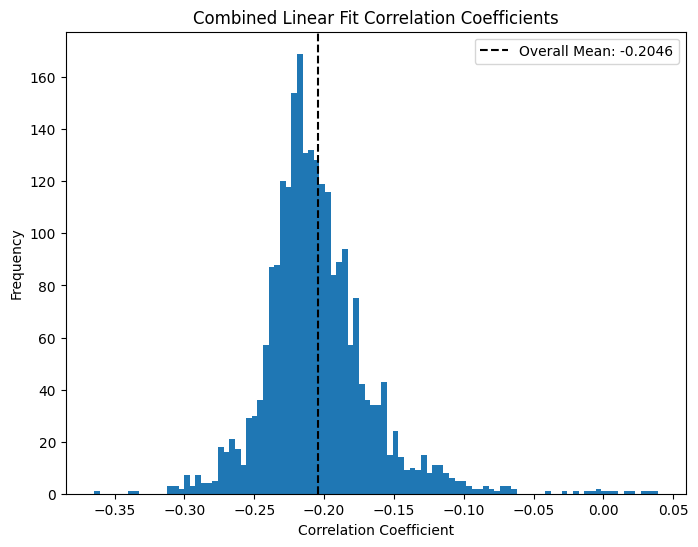

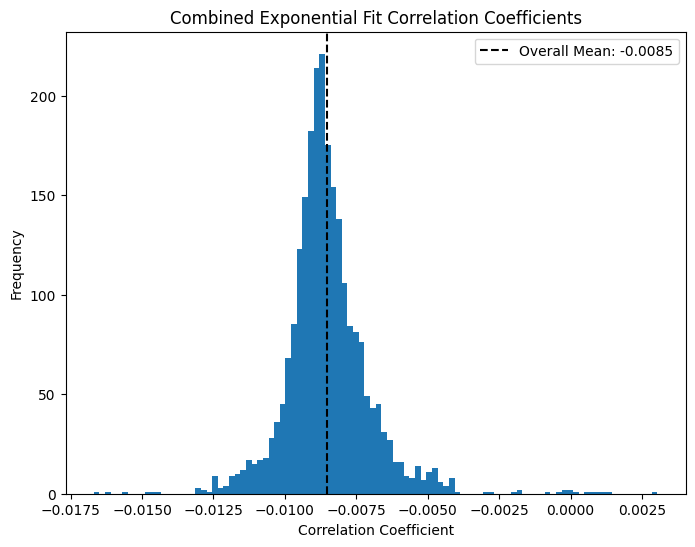

In [42]:
all_filtered_lin = np.concatenate([data[(data > (mean_std_lin[year]['mean_unscaled_lin'] - mean_std_lin[year]['std_unscaled_lin'])) & 
                                        (data < (mean_std_lin[year]['mean_unscaled_lin'] + mean_std_lin[year]['std_unscaled_lin']))]
                                   for year, data in unique_corrCoeff_lin_unsclaed.items()])
all_filtered_exp = np.concatenate([data[(data > (mean_std_exp[year]['mean_unscaled_exp'] - mean_std_exp[year]['std_unscaled_exp'])) & 
                                        (data < (mean_std_exp[year]['mean_unscaled_exp'] + mean_std_exp[year]['std_unscaled_exp']))]
                                   for year, data in unique_corrCoeff_exp_unsclaed.items()])

# Plotting the combined histogram for linear fit
plt.figure(figsize=(8, 6))
plt.hist(all_filtered_lin, bins = 100)
plt.title('Combined Linear Fit Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.axvline(x = all_filtered_lin.mean(), color='black', linestyle='--', label=f'Overall Mean: {all_filtered_lin.mean():.4f}')
plt.legend()
plt.show()

# Plotting the combined histogram for exponential fit
plt.figure(figsize=(8, 6))
plt.hist(all_filtered_exp, bins = 100)
plt.title('Combined Exponential Fit Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.axvline(x=all_filtered_exp.mean(), color='black', linestyle='--', label=f'Overall Mean: {all_filtered_exp.mean():.4f}')
plt.legend()
plt.show()

# Saving the rates and weather in a numpy array for easy access later

In [48]:
# np.save('/home/rykore/rates_data.npy', rates_data)
# np.save('/home/rykore/weather_data.npy', weather_data)
# np.save('/home/rykore/mean_std_lin.npy', mean_std_lin)
# np.save('/home/rykore/mean_std_exp.npy', mean_std_exp)
np.save('/home/rykore/rcorr_final.npy', rcorr_final)

# Corrected Rates

In [47]:
# write a function to get the corrected rates that is similar to this
# this function is not correct, so ask questions and make it better

rcorr_final = {}
# r_mean will be the mean rates value of that year from the mean_std_lin or mean_std_exp dictionary
# slope is the correlation coefficient exp from the weather_data

def get_rcorr():

    for year in years:

        set_xmin, set_xmax = make_plot(year, make_plot = False)

        time_range = set_xmax - set_xmin
        delta = 5.55e-03  # this is 8 mins in units of days
        bins = int(time_range / delta)

        r_h, l = np.histogram(rates_data[year]['mjd_time_rates'], bins, weights = rates_data[year]['rates'] )
        r, l = np.histogram(rates_data[year]['mjd_time_rates'], bins, weights = None)

        normalized_rates = r_h/r # y axis

        p_h, l = np.histogram(weather_data[year]['mjd_time_weather'], bins, weights = weather_data[year]['pressure'])
        p, l = np.histogram(weather_data[year]['mjd_time_weather'], bins, weights = None)

        normalized_pressure = p_h/p

        rcorr = normalized_rates * np.exp(0.0085 * (normalized_pressure - np.mean(normalized_pressure)) )
        
        rcorr_final[year] = {"time" : l[1:], "corrected rates" : rcorr}

get_rcorr()
        

/tmp/ipykernel_1442/752703851.py:21: RuntimeWarning: invalid value encountered in divide
  normalized_rates = r_h/r # y axis


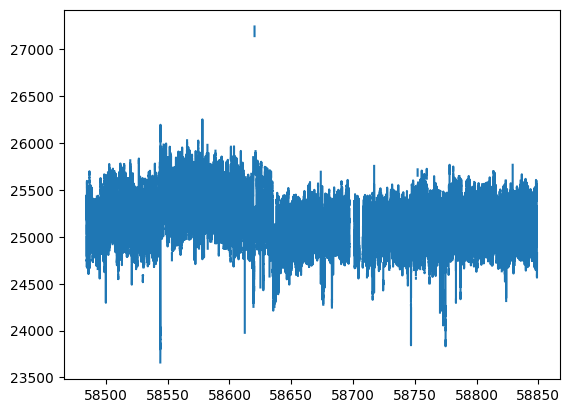

In [49]:
plt.plot(rcorr_final['2019']['time'], rcorr_final['2019']['corrected rates'])

In [50]:
len(weather_data['2020']['CorrCoeff_exp_unscaled'])

527040

In [51]:
rates_data

{'2015': {'mjd_time_rates': array([57143.04541088, 57143.04685764, 57143.0483044 , ...,
         57387.74645255, 57387.74789931, 57387.74934606]),
  'rates': array([10943.367547, 10964.424   , 10945.584   , ..., 23688.77351 ,
         23648.152   , 23637.624   ]),
  'rates_modified': array([10.94336755, 10.964424  , 10.945584  , ..., 23.68877351,
         23.648152  , 23.637624  ]),
  'rates_over_pmt': array([10.96529814, 10.98639679, 10.96751904, ..., 23.06599173,
         23.02643817, 23.01618695])},
 '2016': {'mjd_time_rates': array([57387.75079282, 57387.75223958, 57387.75368634, ...,
         57753.7457379 , 57753.74718464, 57753.74863138]),
  'rates': array([23685.621485, 23678.085425, 23668.368   , ..., 25039.239686,
         25043.2     , 25028.096   ]),
  'rates_modified': array([23.68562148, 23.67808543, 23.668368  , ..., 25.03923969,
         25.0432    , 25.028096  ]),
  'rates_over_pmt': array([23.06292258, 23.05558464, 23.04612269, ..., 22.53756947,
         22.54113411, 

# The Plots

## Year 2015

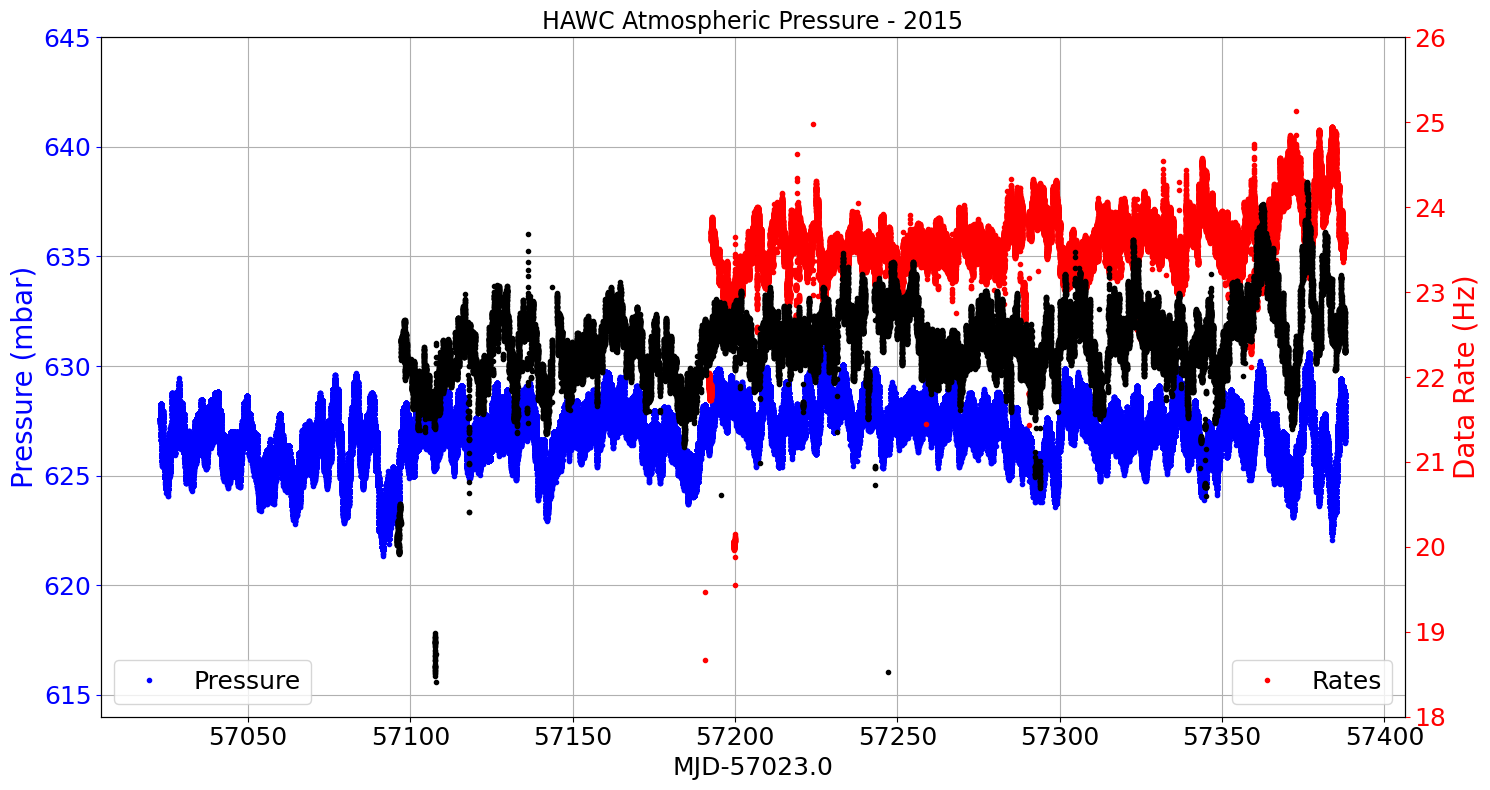

In [56]:
make_plot('2015',614,645,18,26,1.25,True)

## Year 2016

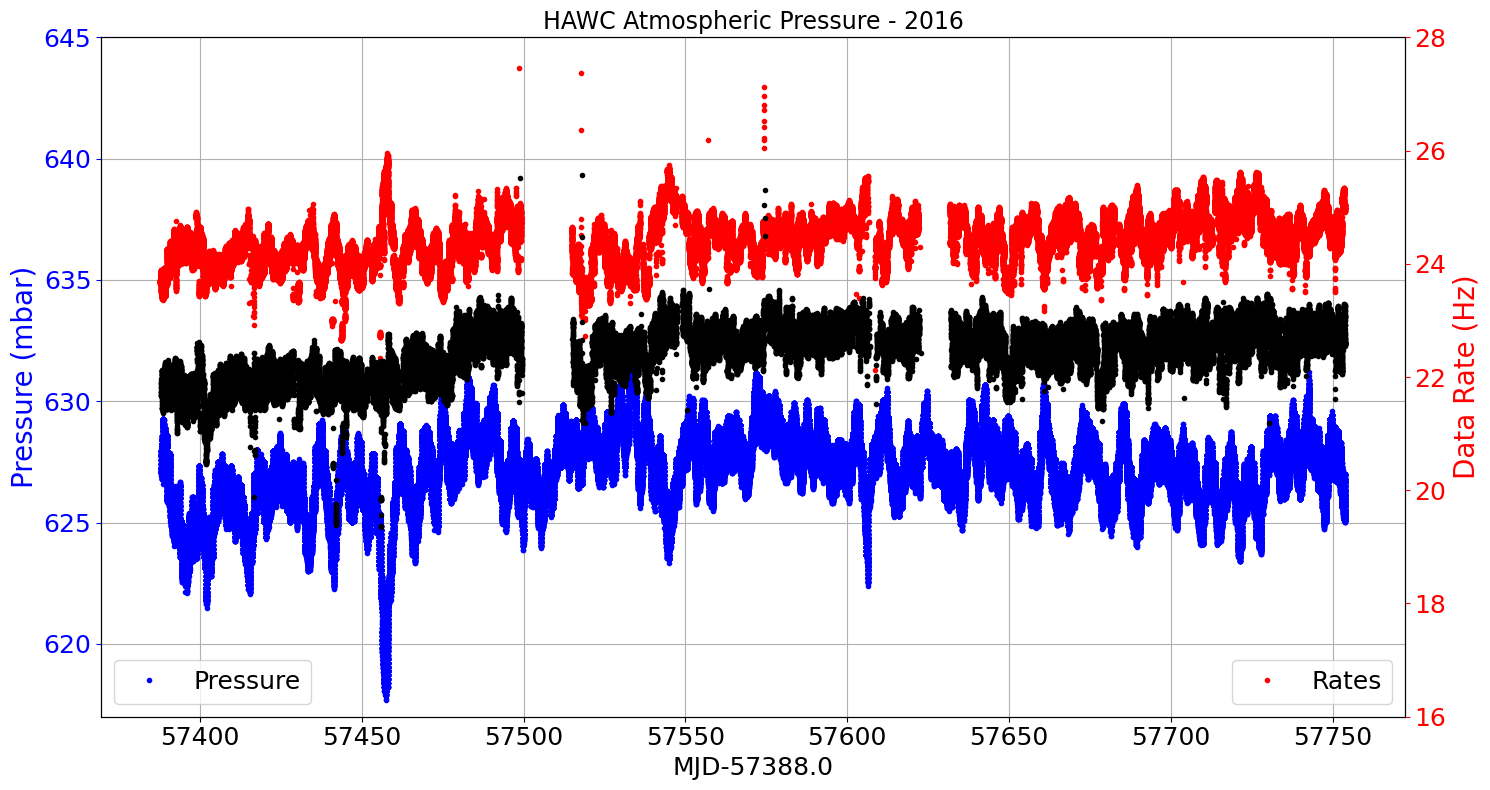

In [53]:
make_plot('2016',617,645,16,28,2,make_plot = True)

## Year 2017

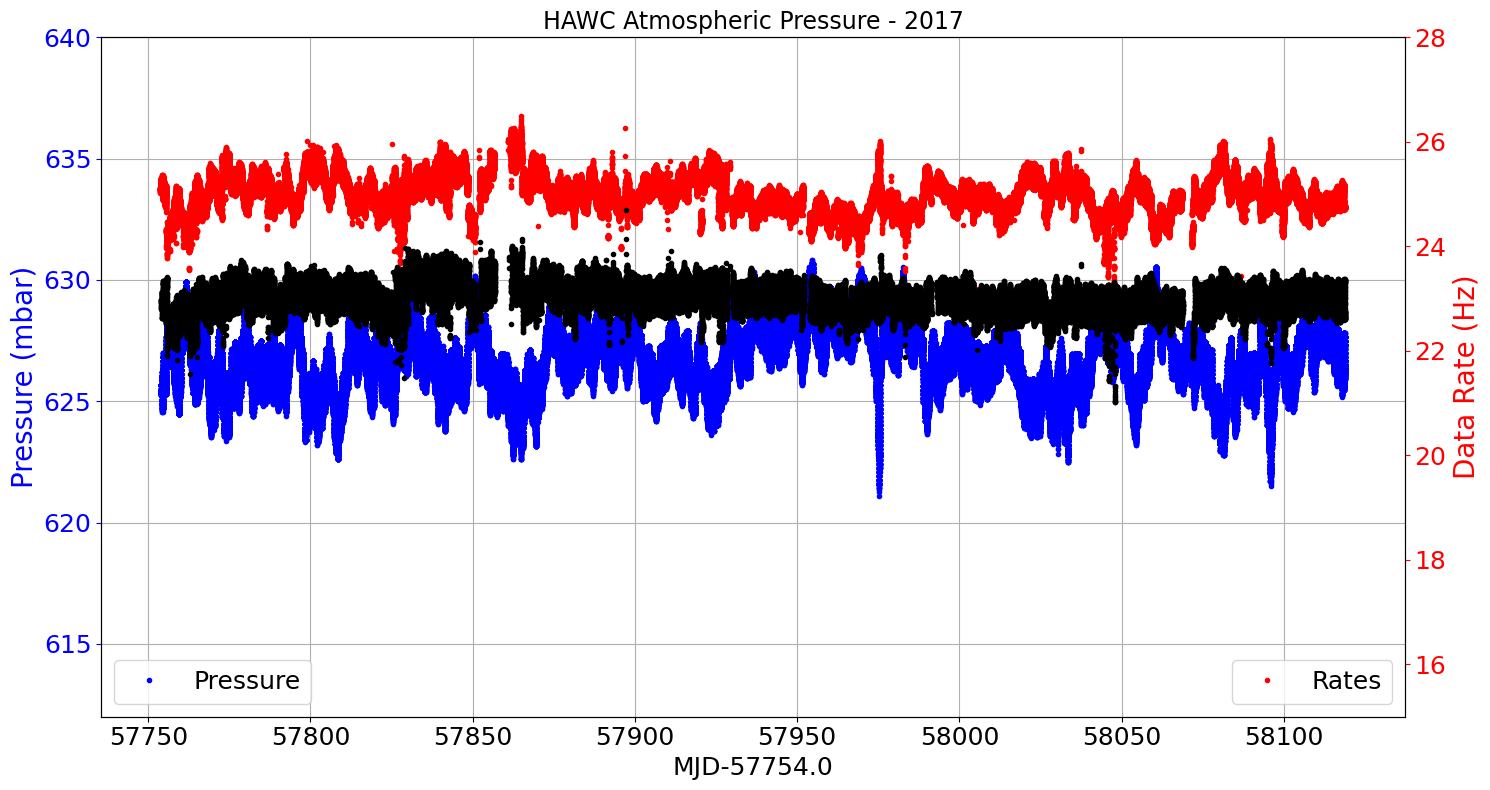

In [54]:
make_plot('2017',612,640,15,28,make_plot = True)

## Year 2018

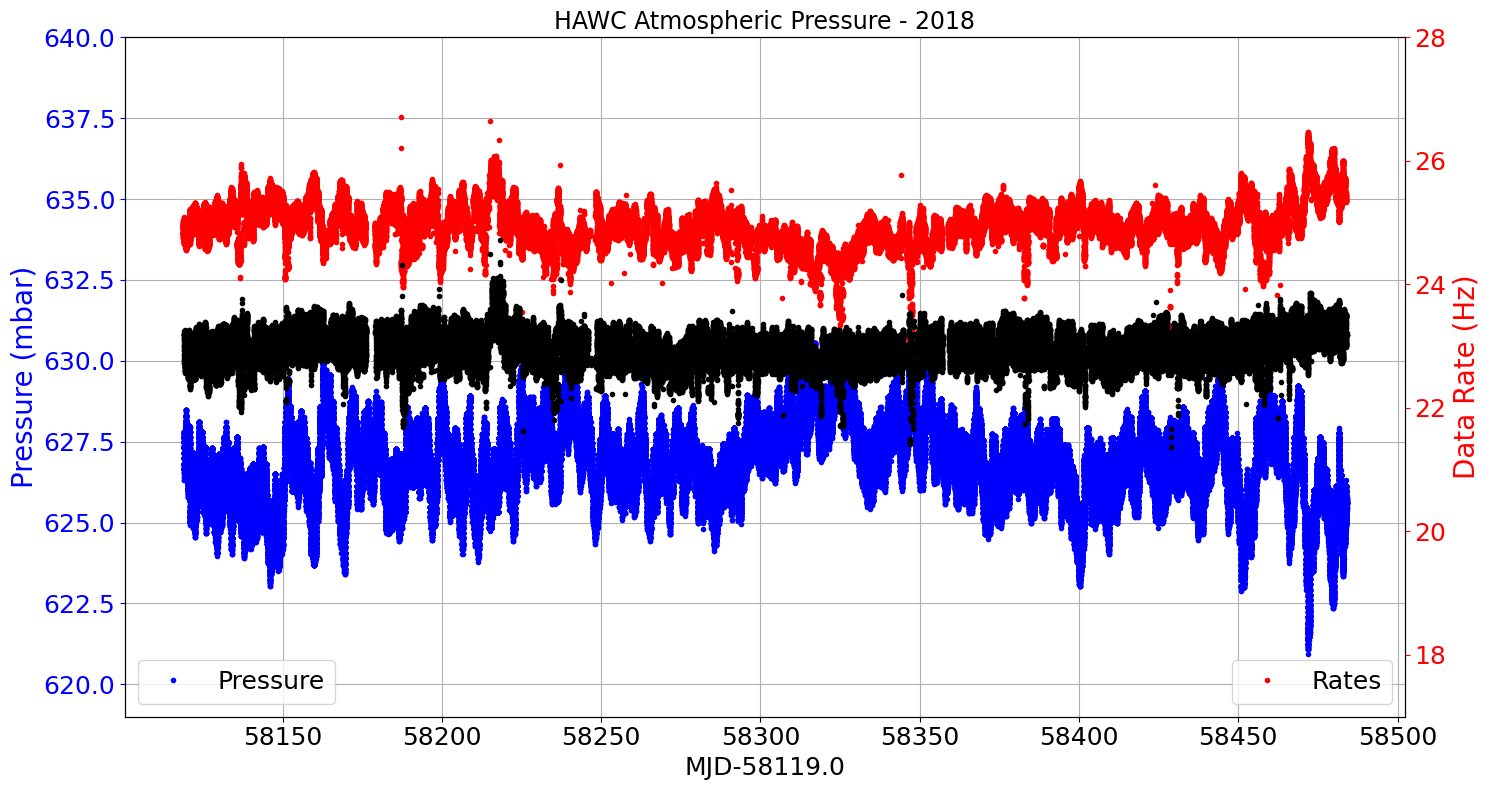

In [57]:
make_plot('2018',619,640,17,28,2, make_plot = True)

## Year 2019

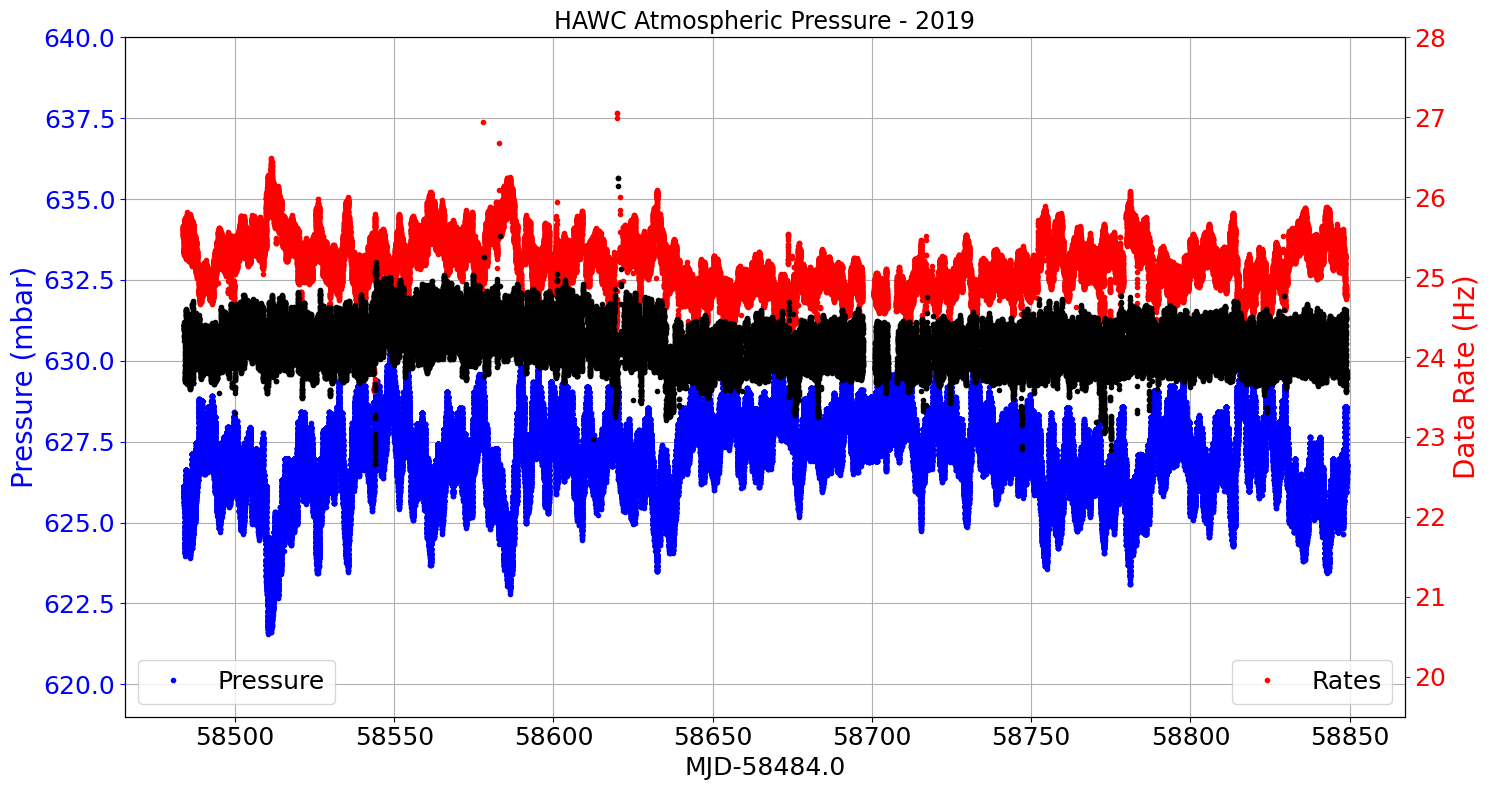

In [58]:
make_plot('2019',619,640,19.5,28,1,make_plot = True)

## Year 2020

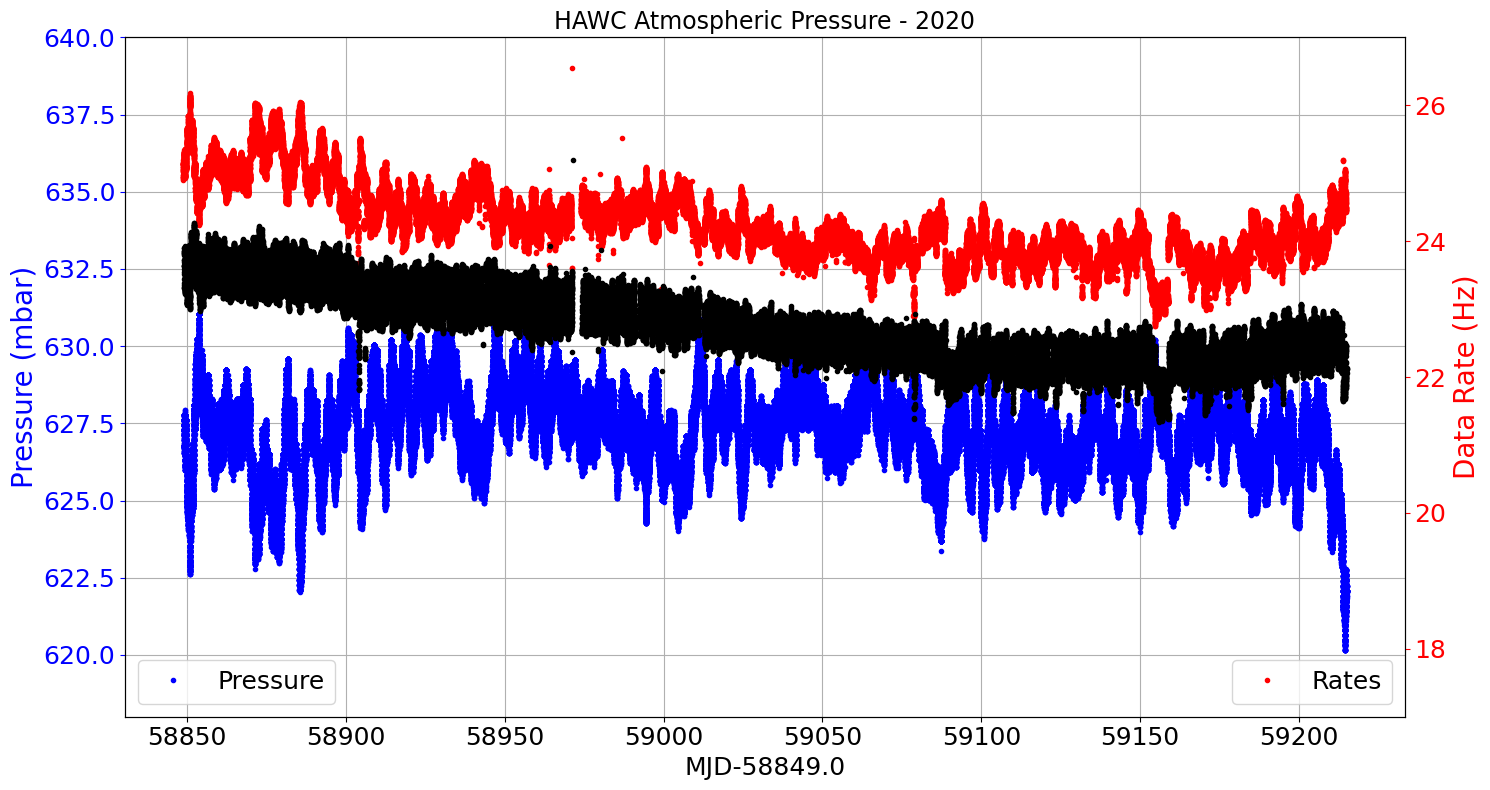

In [59]:
make_plot('2020',618,640,17,27,1.5,make_plot = True)

## Year 2021

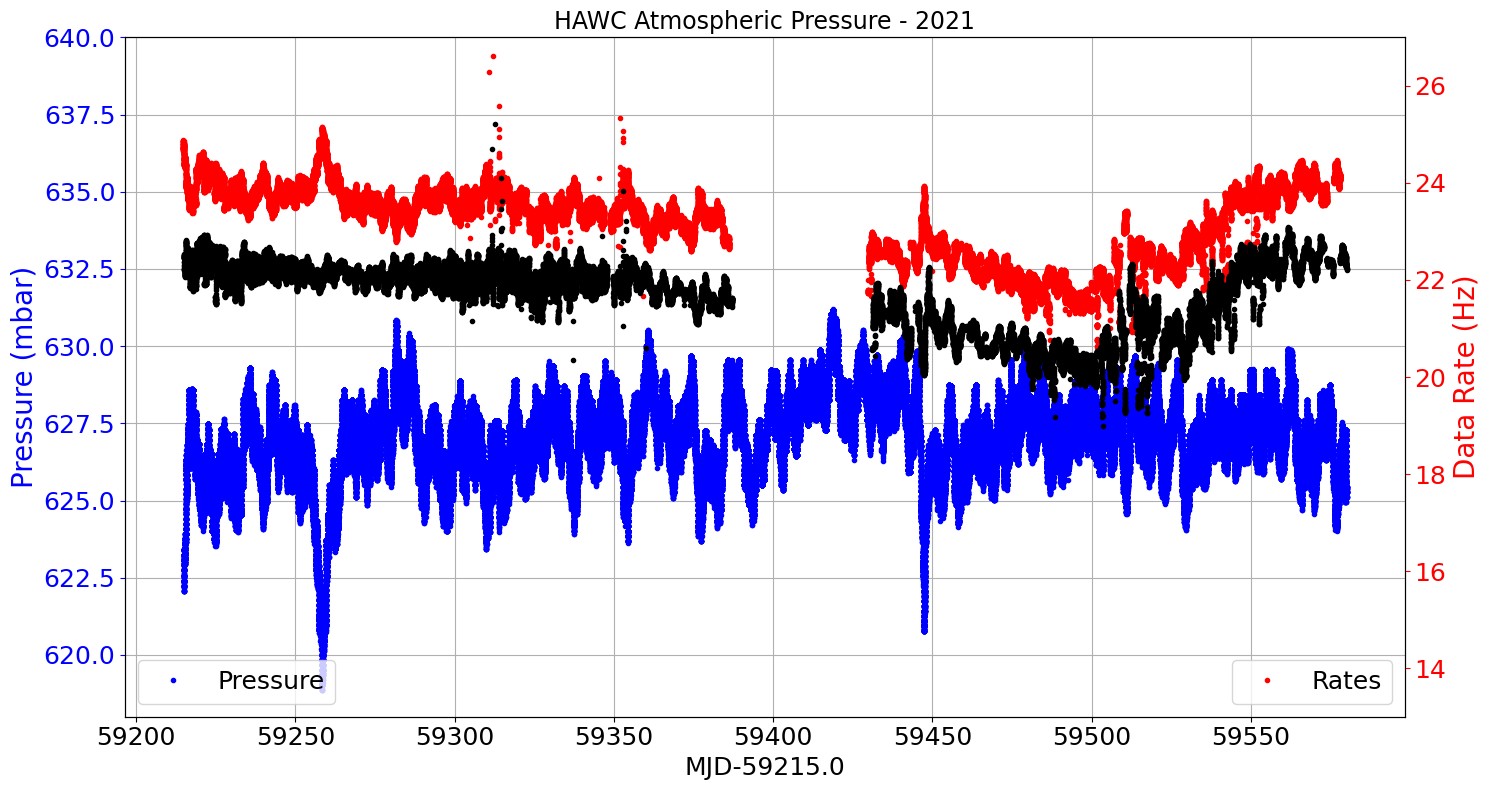

In [60]:
make_plot('2021',618,640,13,27,1.5, make_plot = True)

## Year 2022

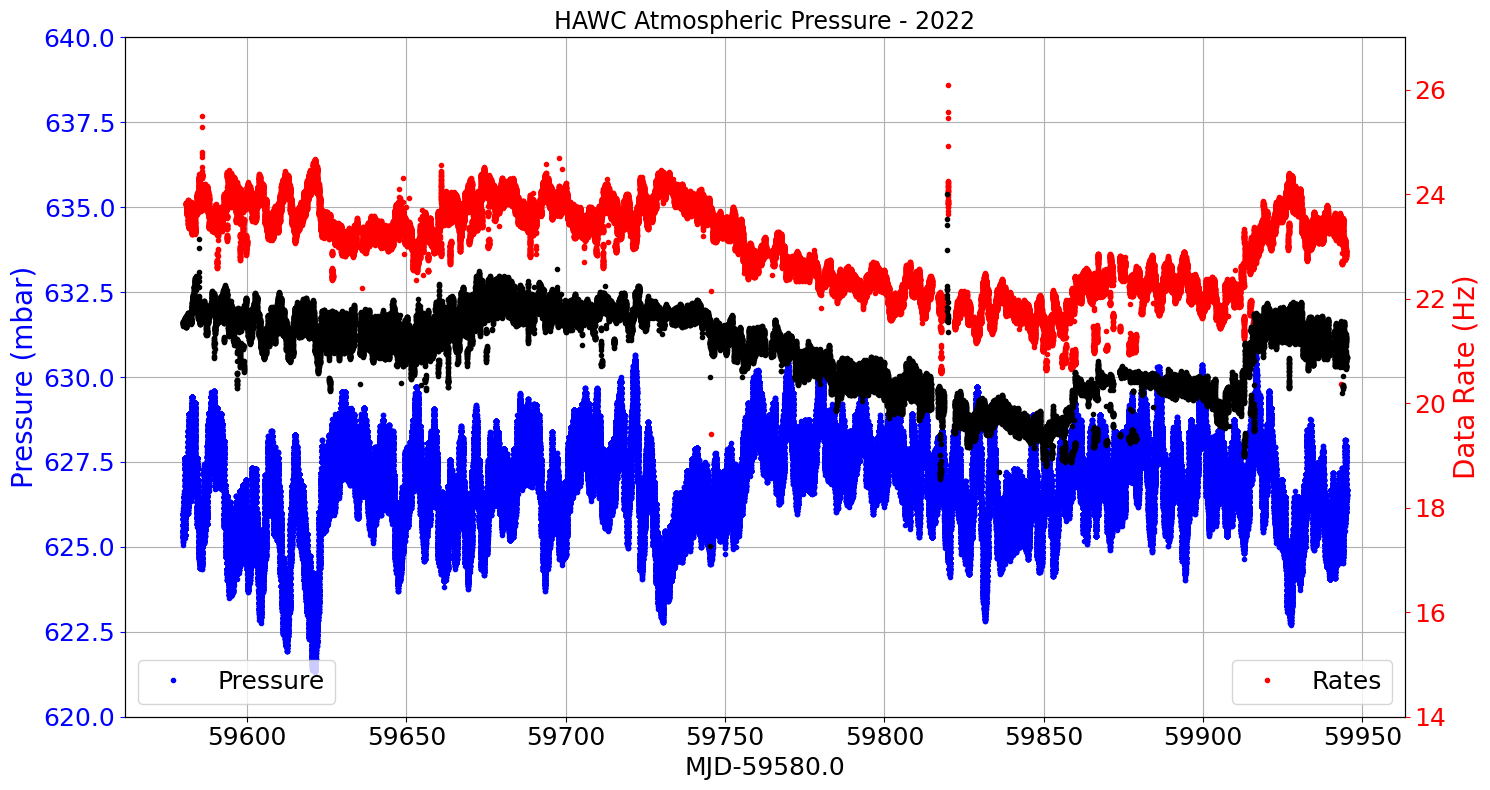

In [61]:
make_plot('2022',620,640,14,27,2,make_plot = True)

## Year 2023

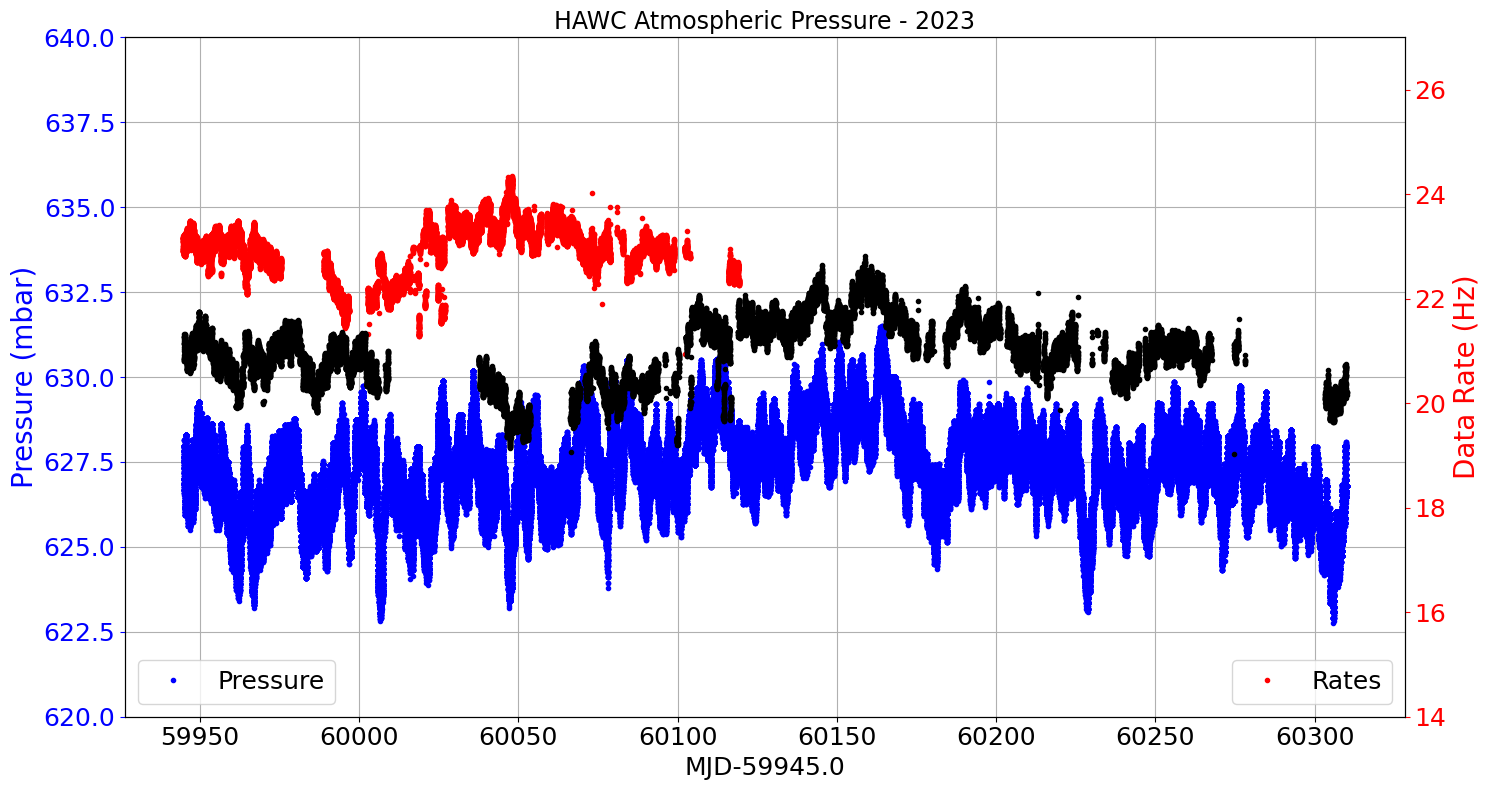

In [64]:
make_plot('2023',620,640,14,27,2,make_plot = True)